# Misc Experiments

Testing different architectures, scaling, etc.

In [11]:
# Setup taken from notebook 17.

import itertools
import sys

import bson
import h5py
import keras.layers
import keras.models
import matplotlib.pyplot
import numpy
import pandas
import sklearn.cross_validation
import sklearn.dummy
import sklearn.linear_model
import sklearn.metrics

sys.path.insert(1, '..')
import crowdastro.data
import crowdastro.show

with pandas.HDFStore('../crowdastro-data/training.h5') as store:
    data = store['data']

n = 5000

# I'm gathering up the radio patches first so I can run them through the CNN at the same time
# as one big matrix operation. In principle this would run on the GPU.
radio_patches = numpy.zeros((n, 80, 80))
labels = numpy.zeros((n,))
linear_distances = numpy.zeros((n,))

radius = 40
padding = 150

for idx, row in data.head(n).iterrows():
    sid = bson.objectid.ObjectId(row['subject_id'][0].decode('ascii'))
    x = row['x'][0]
    y = row['y'][0]
    label = row['is_host'][0]
    
    labels[idx] = label
    
    subject = crowdastro.data.db.radio_subjects.find_one({'_id': sid})
    radio = crowdastro.data.get_radio(subject, size='5x5')
    patch = radio[x - radius + padding : x + radius + padding, y - radius + padding : y + radius + padding]
    radio_patches[idx, :] = patch
    
    linear_distances[idx] = numpy.hypot(x - 100, y - 100)

# Load the CNN.

with open('../crowdastro-data/cnn_model_2.json', 'r') as f:
    cnn = keras.models.model_from_json(f.read())

cnn.load_weights('../crowdastro-data/cnn_weights_2.h5')

cnn.layers = cnn.layers[:5]  # Pop the layers after the second convolution's activation.
cnn.add(keras.layers.Flatten())

cnn.compile(optimizer='sgd', loss='mse')  # I don't actually care about the optimiser or loss.

# Load the PCA.
with h5py.File('../crowdastro-data/pca.h5') as f:
    pca = f['conv_2'][:]

# Find the radio features.
radio_features = cnn.predict(radio_patches.reshape(n, 1, 80, 80)) @ pca.T

# Add on the astronomy features.
features = numpy.hstack([radio_features, data.ix[:n-1, 'flux_ap2_24':'flux_ap2_80'].as_matrix(),
                         linear_distances.reshape(-1, 1)])
features = numpy.nan_to_num(features)

K:\Languages\Anaconda3\lib\site-packages\astropy\io\fits\util.py:578: UserWarning: Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.
  'Could not find appropriate MS Visual C Runtime '
K:\Languages\Anaconda3\lib\site-packages\ipykernel\__main__.py:46: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [12]:
subject_ids = set()
for idx, row in data.ix[n:n * 2].iterrows():
    sid = row['subject_id'][0]
    subject_ids.add(sid)

## Baseline &mdash; logistic regression with CNN, astro, and distance features

In [13]:
def test(features, labels):
    xs_train, xs_test, ts_train, ts_test = sklearn.cross_validation.train_test_split(
            features, labels, test_size=0.2, random_state=0)
    lr = sklearn.linear_model.LogisticRegression(class_weight='balanced')
    lr.fit(xs_train, ts_train)
    print('Classification accuracy: {:.02%}'.format(lr.score(xs_test, ts_test)))

    hits = 0
    attempts = 0

    for subject_id in subject_ids:
        indices = (data['subject_id'] == subject_id).as_matrix().reshape(-1)
        potential_hosts = numpy.nan_to_num(data.as_matrix()[indices][:, 1:-1].astype(float))
        labels = numpy.nan_to_num(data.as_matrix()[indices][:, -1].astype(bool))

        subject = crowdastro.data.db.radio_subjects.find_one({'_id': bson.objectid.ObjectId(subject_id.decode('ascii'))})
        radio = crowdastro.data.get_radio(subject, size='5x5')

        radio_patches = numpy.zeros((len(potential_hosts), 1, radius * 2, radius * 2))
        linear_features = numpy.zeros((len(potential_hosts),))
        for index, (x, y, *astro) in enumerate(potential_hosts):
            patch = radio[x - radius + padding : x + radius + padding, y - radius + padding : y + radius + padding]
            radio_patches[index, 0, :] = patch
            linear_features[index] = numpy.hypot(x - 100, y - 100)

        radio_features = cnn.predict(radio_patches) @ pca.T
        astro_features = potential_hosts[:, 2:]
        features = numpy.hstack([radio_features, astro_features, linear_features.reshape(-1, 1)])

        scores = lr.predict_proba(features)[:, 1].reshape(-1)
        predicted_host = scores.argmax()
        if labels[predicted_host]:
            hits += 1
        attempts += 1

    print('Problem accuracy: {:.02%}'.format(hits / attempts))

test(features, labels)

Classification accuracy: 87.90%
Problem accuracy: 63.04%


K:\Languages\Anaconda3\lib\site-packages\astropy\io\fits\util.py:578: UserWarning: Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.
  'Could not find appropriate MS Visual C Runtime '
K:\Languages\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## Scaling inputs

In [16]:
import sklearn.preprocessing

def test(features, labels):
    xs_train, xs_test, ts_train, ts_test = sklearn.cross_validation.train_test_split(
            features, labels, test_size=0.2, random_state=0)

    scaler = sklearn.preprocessing.StandardScaler().fit(xs_train)
    xs_train = scaler.transform(xs_train)
    xs_test = scaler.transform(xs_test)

    lr = sklearn.linear_model.LogisticRegression(class_weight='balanced')
    lr.fit(xs_train, ts_train)
    print('Classification accuracy: {:.02%}'.format(lr.score(xs_test, ts_test)))

    hits = 0
    attempts = 0

    for subject_id in subject_ids:
        indices = (data['subject_id'] == subject_id).as_matrix().reshape(-1)
        potential_hosts = numpy.nan_to_num(data.as_matrix()[indices][:, 1:-1].astype(float))
        labels = numpy.nan_to_num(data.as_matrix()[indices][:, -1].astype(bool))

        subject = crowdastro.data.db.radio_subjects.find_one({'_id': bson.objectid.ObjectId(subject_id.decode('ascii'))})
        radio = crowdastro.data.get_radio(subject, size='5x5')

        radio_patches = numpy.zeros((len(potential_hosts), 1, radius * 2, radius * 2))
        linear_features = numpy.zeros((len(potential_hosts), 1))
        for index, (x, y, *astro) in enumerate(potential_hosts):
            patch = radio[x - radius + padding : x + radius + padding, y - radius + padding : y + radius + padding]
            radio_patches[index, 0, :] = patch
            linear_features[index] = numpy.hypot(x - 100, y - 100)

        radio_features = cnn.predict(radio_patches) @ pca.T
        astro_features = potential_hosts[:, 2:]
        features = numpy.hstack([radio_features, astro_features, linear_features])
        features = scaler.transform(features)

        scores = lr.predict_proba(features)[:, 1].reshape(-1)
        predicted_host = scores.argmax()
        if labels[predicted_host]:
            hits += 1
        attempts += 1

    print('Problem accuracy: {:.02%}'.format(hits / attempts))

test(features, labels)

Classification accuracy: 89.30%
Problem accuracy: 66.67%


K:\Languages\Anaconda3\lib\site-packages\astropy\io\fits\util.py:578: UserWarning: Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.
  'Could not find appropriate MS Visual C Runtime '
K:\Languages\Anaconda3\lib\site-packages\ipykernel\__main__.py:29: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Scaling inputs = good. This isn't terribly surprising.

In [17]:
def test(features):
    scaler = sklearn.preprocessing.StandardScaler().fit(features)
    return scaler.scale_

print(test(features))

[ 9051.42212008  6953.31190208  5349.40960212  4968.09659438  4748.00417295
  4128.26707002  3973.44009544  3850.95056158  3254.29090605  3144.60446994
  3139.61706514  2951.62978676  2853.34042125  2590.76258015  2510.6449221
  2331.22286583  2200.48536758  2216.61284962  2096.1111806   2065.47898944
  1977.87418018  1837.65344625  1719.67276548  1667.69828113  1648.61686651
  1577.00551856  1461.90867471  1466.62265086  1378.87218405  1387.71507698
  1347.98422503  1231.0283547   1211.18675808  1170.03695302  1118.6749525
  1061.06654488  1011.71606249   954.3065446    937.22720446   928.4765574
   896.1907569    886.61445223   831.72692784   834.72755708   780.69628099
   766.78930766   765.57900416   727.94720156   719.26123538   685.36683335
   678.34783191   696.24279327   656.15186468   691.17002161   650.64161914
   620.28148017   627.07619535   601.05443505   600.52196732   583.55252599
   556.59690537   553.01077157   543.71788942   514.27114502   509.44826491
   500.41990105

## Negative/positive labels (instead of binary)

In [21]:
def test(features, labels):
    labels = labels * 2 - 1
    xs_train, xs_test, ts_train, ts_test = sklearn.cross_validation.train_test_split(
            features, labels, test_size=0.2, random_state=0)

    lr = sklearn.linear_model.LogisticRegression(class_weight='balanced')
    lr.fit(xs_train, ts_train)
    print('Classification accuracy: {:.02%}'.format(lr.score(xs_test, ts_test)))

    hits = 0
    attempts = 0

    for subject_id in subject_ids:
        indices = (data['subject_id'] == subject_id).as_matrix().reshape(-1)
        potential_hosts = numpy.nan_to_num(data.as_matrix()[indices][:, 1:-1].astype(float))
        labels = numpy.nan_to_num(data.as_matrix()[indices][:, -1].astype(bool)) * 2 - 1

        subject = crowdastro.data.db.radio_subjects.find_one({'_id': bson.objectid.ObjectId(subject_id.decode('ascii'))})
        radio = crowdastro.data.get_radio(subject, size='5x5')

        radio_patches = numpy.zeros((len(potential_hosts), 1, radius * 2, radius * 2))
        linear_features = numpy.zeros((len(potential_hosts), 1))
        for index, (x, y, *astro) in enumerate(potential_hosts):
            patch = radio[x - radius + padding : x + radius + padding, y - radius + padding : y + radius + padding]
            radio_patches[index, 0, :] = patch
            linear_features[index] = numpy.hypot(x - 100, y - 100)

        radio_features = cnn.predict(radio_patches) @ pca.T
        astro_features = potential_hosts[:, 2:]
        features = numpy.hstack([radio_features, astro_features, linear_features])

        scores = lr.predict_proba(features)[:, 1].reshape(-1)
        predicted_host = scores.argmax()
        if labels[predicted_host] == 1:
            hits += 1
        attempts += 1

    print('Problem accuracy: {:.02%}'.format(hits / attempts))

test(features, labels)

Classification accuracy: 87.90%
Problem accuracy: 63.04%


K:\Languages\Anaconda3\lib\site-packages\astropy\io\fits\util.py:578: UserWarning: Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.
  'Could not find appropriate MS Visual C Runtime '
K:\Languages\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


This had no effect (maybe sklearn does this internally?).

## Normalising

In [27]:
def test(features, labels):
    xs_train, xs_test, ts_train, ts_test = sklearn.cross_validation.train_test_split(
            features, labels, test_size=0.2, random_state=0)

    normaliser = sklearn.preprocessing.Normalizer()
    xs_train = normaliser.transform(xs_train)
    xs_test = normaliser.transform(xs_test)

    lr = sklearn.linear_model.LogisticRegression(class_weight='balanced')
    lr.fit(xs_train, ts_train)
    print('Classification accuracy: {:.02%}'.format(lr.score(xs_test, ts_test)))

    hits = 0
    attempts = 0

    for subject_id in subject_ids:
        indices = (data['subject_id'] == subject_id).as_matrix().reshape(-1)
        potential_hosts = numpy.nan_to_num(data.as_matrix()[indices][:, 1:-1].astype(float))
        labels = numpy.nan_to_num(data.as_matrix()[indices][:, -1].astype(bool))

        subject = crowdastro.data.db.radio_subjects.find_one({'_id': bson.objectid.ObjectId(subject_id.decode('ascii'))})
        radio = crowdastro.data.get_radio(subject, size='5x5')

        radio_patches = numpy.zeros((len(potential_hosts), 1, radius * 2, radius * 2))
        linear_features = numpy.zeros((len(potential_hosts), 1))
        for index, (x, y, *astro) in enumerate(potential_hosts):
            patch = radio[x - radius + padding : x + radius + padding, y - radius + padding : y + radius + padding]
            radio_patches[index, 0, :] = patch
            linear_features[index] = numpy.hypot(x - 100, y - 100)

        radio_features = cnn.predict(radio_patches) @ pca.T
        astro_features = potential_hosts[:, 2:]
        features = numpy.hstack([radio_features, astro_features, linear_features])
        features = normaliser.transform(features)

        scores = lr.predict_proba(features)[:, 1].reshape(-1)
        predicted_host = scores.argmax()
        if labels[predicted_host]:
            hits += 1
        attempts += 1

    print('Problem accuracy: {:.02%}'.format(hits / attempts))

test(features, labels)

Classification accuracy: 83.10%
Problem accuracy: 78.26%


K:\Languages\Anaconda3\lib\site-packages\astropy\io\fits\util.py:578: UserWarning: Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.
  'Could not find appropriate MS Visual C Runtime '
K:\Languages\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Normalising massively raises the accuracy. This isn't surprising by itself, but the size of the accuracy gain is surprising.

## Scaling and normalising

In [26]:
def test(features, labels):
    xs_train, xs_test, ts_train, ts_test = sklearn.cross_validation.train_test_split(
            features, labels, test_size=0.2, random_state=0)

    normaliser = sklearn.preprocessing.Normalizer()
    scaler = sklearn.preprocessing.StandardScaler().fit(normaliser.transform(xs_train))
    xs_train = scaler.transform(normaliser.transform(xs_train))
    xs_test = scaler.transform(normaliser.transform(xs_test))

    lr = sklearn.linear_model.LogisticRegression(class_weight='balanced')
    lr.fit(xs_train, ts_train)
    print('Classification accuracy: {:.02%}'.format(lr.score(xs_test, ts_test)))

    hits = 0
    attempts = 0

    for subject_id in subject_ids:
        indices = (data['subject_id'] == subject_id).as_matrix().reshape(-1)
        potential_hosts = numpy.nan_to_num(data.as_matrix()[indices][:, 1:-1].astype(float))
        labels = numpy.nan_to_num(data.as_matrix()[indices][:, -1].astype(bool))

        subject = crowdastro.data.db.radio_subjects.find_one({'_id': bson.objectid.ObjectId(subject_id.decode('ascii'))})
        radio = crowdastro.data.get_radio(subject, size='5x5')

        radio_patches = numpy.zeros((len(potential_hosts), 1, radius * 2, radius * 2))
        linear_features = numpy.zeros((len(potential_hosts), 1))
        for index, (x, y, *astro) in enumerate(potential_hosts):
            patch = radio[x - radius + padding : x + radius + padding, y - radius + padding : y + radius + padding]
            radio_patches[index, 0, :] = patch
            linear_features[index] = numpy.hypot(x - 100, y - 100)

        radio_features = cnn.predict(radio_patches) @ pca.T
        astro_features = potential_hosts[:, 2:]
        features = numpy.hstack([radio_features, astro_features, linear_features])
        features = scaler.transform(normaliser.transform(features))

        scores = lr.predict_proba(features)[:, 1].reshape(-1)
        predicted_host = scores.argmax()
        if labels[predicted_host]:
            hits += 1
        attempts += 1

    print('Problem accuracy: {:.02%}'.format(hits / attempts))

test(features, labels)

Classification accuracy: 76.10%
Problem accuracy: 70.29%


K:\Languages\Anaconda3\lib\site-packages\astropy\io\fits\util.py:578: UserWarning: Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.
  'Could not find appropriate MS Visual C Runtime '
K:\Languages\Anaconda3\lib\site-packages\ipykernel\__main__.py:28: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


While better than scaling alone, this is worse than just normalising. I wonder if there's a relationship between the scales of the CNN features that we're missing somehow when we scale? To test this, I'll normalise all the data, but only scale the last 6 features.

In [28]:
def test(features, labels):
    xs_train, xs_test, ts_train, ts_test = sklearn.cross_validation.train_test_split(
            features, labels, test_size=0.2, random_state=0)

    normaliser = sklearn.preprocessing.Normalizer()
    scaler = sklearn.preprocessing.StandardScaler().fit(normaliser.transform(xs_train[:, -6:]))
    xs_train = numpy.hstack([normaliser.transform(xs_train[:, :-6]),
                             scaler.transform(normaliser.transform(xs_train[:, -6:]))])
    xs_test = numpy.hstack([normaliser.transform(xs_test[:, :-6]),
                             scaler.transform(normaliser.transform(xs_test[:, -6:]))])

    lr = sklearn.linear_model.LogisticRegression(class_weight='balanced')
    lr.fit(xs_train, ts_train)
    print('Classification accuracy: {:.02%}'.format(lr.score(xs_test, ts_test)))

    hits = 0
    attempts = 0

    for subject_id in subject_ids:
        indices = (data['subject_id'] == subject_id).as_matrix().reshape(-1)
        potential_hosts = numpy.nan_to_num(data.as_matrix()[indices][:, 1:-1].astype(float))
        labels = numpy.nan_to_num(data.as_matrix()[indices][:, -1].astype(bool))

        subject = crowdastro.data.db.radio_subjects.find_one({'_id': bson.objectid.ObjectId(subject_id.decode('ascii'))})
        radio = crowdastro.data.get_radio(subject, size='5x5')

        radio_patches = numpy.zeros((len(potential_hosts), 1, radius * 2, radius * 2))
        linear_features = numpy.zeros((len(potential_hosts), 1))
        for index, (x, y, *astro) in enumerate(potential_hosts):
            patch = radio[x - radius + padding : x + radius + padding, y - radius + padding : y + radius + padding]
            radio_patches[index, 0, :] = patch
            linear_features[index] = numpy.hypot(x - 100, y - 100)

        radio_features = cnn.predict(radio_patches) @ pca.T
        astro_features = potential_hosts[:, 2:]
        features = numpy.hstack([radio_features, astro_features, linear_features])
        features = numpy.hstack([normaliser.transform(features[:, :-6]),
                                 scaler.transform(normaliser.transform(features[:, -6:]))])

        scores = lr.predict_proba(features)[:, 1].reshape(-1)
        predicted_host = scores.argmax()
        if labels[predicted_host]:
            hits += 1
        attempts += 1

    print('Problem accuracy: {:.02%}'.format(hits / attempts))

test(features, labels)

Classification accuracy: 80.10%
Problem accuracy: 82.61%


K:\Languages\Anaconda3\lib\site-packages\astropy\io\fits\util.py:578: UserWarning: Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.
  'Could not find appropriate MS Visual C Runtime '
K:\Languages\Anaconda3\lib\site-packages\ipykernel\__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


That worked really well. I'll have to find out why. I'll try looking at the output of one of the more difficult-to-classify subjects.

K:\Languages\Anaconda3\lib\site-packages\astropy\io\fits\util.py:578: UserWarning: Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.
  'Could not find appropriate MS Visual C Runtime '


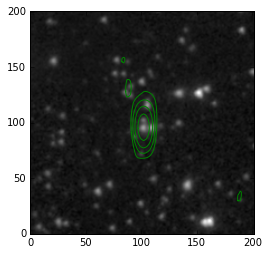

In [29]:
%matplotlib inline
subject = crowdastro.data.db.radio_subjects.find_one({'zooniverse_id': 'ARG0003r8e'})
crowdastro.show.subject(subject)

Classification accuracy: 80.10%


K:\Languages\Anaconda3\lib\site-packages\astropy\io\fits\util.py:578: UserWarning: Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.
  'Could not find appropriate MS Visual C Runtime '
K:\Languages\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


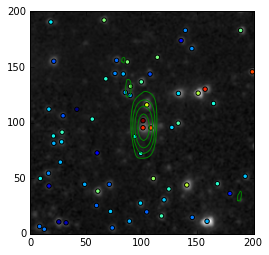

In [37]:
def test(features, labels, subject):
    xs_train, xs_test, ts_train, ts_test = sklearn.cross_validation.train_test_split(
            features, labels, test_size=0.2, random_state=0)

    normaliser = sklearn.preprocessing.Normalizer()
    scaler = sklearn.preprocessing.StandardScaler().fit(normaliser.transform(xs_train[:, -6:]))
    xs_train = numpy.hstack([normaliser.transform(xs_train[:, :-6]),
                             scaler.transform(normaliser.transform(xs_train[:, -6:]))])
    xs_test = numpy.hstack([normaliser.transform(xs_test[:, :-6]),
                             scaler.transform(normaliser.transform(xs_test[:, -6:]))])

    lr = sklearn.linear_model.LogisticRegression(class_weight='balanced')
    lr.fit(xs_train, ts_train)
    print('Classification accuracy: {:.02%}'.format(lr.score(xs_test, ts_test)))

    subject_id = str(subject['_id']).encode('ascii')
    indices = (data['subject_id'] == subject_id).as_matrix().reshape(-1)
    potential_hosts = numpy.nan_to_num(data.as_matrix()[indices][:, 1:-1].astype(float))
    labels = numpy.nan_to_num(data.as_matrix()[indices][:, -1].astype(bool))

    radio = crowdastro.data.get_radio(subject, size='5x5')

    radio_patches = numpy.zeros((len(potential_hosts), 1, radius * 2, radius * 2))
    linear_features = numpy.zeros((len(potential_hosts), 1))
    for index, (x, y, *astro) in enumerate(potential_hosts):
        patch = radio[x - radius + padding : x + radius + padding, y - radius + padding : y + radius + padding]
        radio_patches[index, 0, :] = patch
        linear_features[index] = numpy.hypot(x - 100, y - 100)

    radio_features = cnn.predict(radio_patches) @ pca.T
    astro_features = potential_hosts[:, 2:]
    features = numpy.hstack([radio_features, astro_features, linear_features])
    features = numpy.hstack([normaliser.transform(features[:, :-6]),
                             scaler.transform(normaliser.transform(features[:, -6:]))])

    scores = lr.predict_proba(features)[:, 1].reshape(-1)
    crowdastro.show.subject(subject)
    matplotlib.pyplot.scatter(potential_hosts[:, 0], potential_hosts[:, 1], c=scores)
    matplotlib.pyplot.show()
    
    return normaliser, scaler, lr

normaliser, scaler, classifier = test(features, labels, subject)

Interestingly, this classifier does a lot better at finding the middle of the compact source. It also highlights some odd points off to the side.

What happens if we run the entropy check over all the data with this classify? What does this classifier consider "hard"?

In [39]:
def softmax(x):
    exp = numpy.exp(x)
    return exp / numpy.sum(exp, axis=0)

def test(features, labels, normaliser, scaler, lr):
    max_entropy = float('-inf')
    max_subject = None

    for subject_id in subject_ids:
        indices = (data['subject_id'] == subject_id).as_matrix().reshape(-1)
        potential_hosts = numpy.nan_to_num(data.as_matrix()[indices][:, 1:-1].astype(float))
        labels = numpy.nan_to_num(data.as_matrix()[indices][:, -1].astype(bool))

        subject = crowdastro.data.db.radio_subjects.find_one({'_id': bson.objectid.ObjectId(subject_id.decode('ascii'))})
        radio = crowdastro.data.get_radio(subject, size='5x5')

        radio_patches = numpy.zeros((len(potential_hosts), 1, radius * 2, radius * 2))
        linear_features = numpy.zeros((len(potential_hosts), 1))
        for index, (x, y, *astro) in enumerate(potential_hosts):
            patch = radio[x - radius + padding : x + radius + padding, y - radius + padding : y + radius + padding]
            radio_patches[index, 0, :] = patch
            linear_features[index] = numpy.hypot(x - 100, y - 100)

        radio_features = cnn.predict(radio_patches) @ pca.T
        astro_features = potential_hosts[:, 2:]
        features = numpy.hstack([radio_features, astro_features, linear_features])
        features = numpy.hstack([normaliser.transform(features[:, :-6]),
                                 scaler.transform(normaliser.transform(features[:, -6:]))])

        probabilities = softmax(lr.predict_proba(features)[:, 1].reshape(-1))
        entropy = -(probabilities * numpy.log(probabilities)).sum()

        if entropy > max_entropy:
            max_entropy = entropy
            max_subject = subject
    
    return max_subject

max_subject = test(features, labels, normaliser, scaler, classifier)

K:\Languages\Anaconda3\lib\site-packages\astropy\io\fits\util.py:578: UserWarning: Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.
  'Could not find appropriate MS Visual C Runtime '
K:\Languages\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


K:\Languages\Anaconda3\lib\site-packages\astropy\io\fits\util.py:578: UserWarning: Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.
  'Could not find appropriate MS Visual C Runtime '


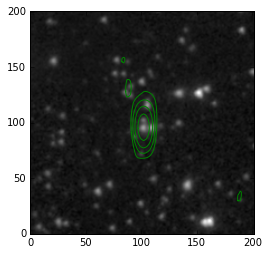

In [40]:
crowdastro.show.subject(max_subject)

Looks like this one is still hard to classify.

Classification accuracy: 80.10%


K:\Languages\Anaconda3\lib\site-packages\astropy\io\fits\util.py:578: UserWarning: Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.
  'Could not find appropriate MS Visual C Runtime '
K:\Languages\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


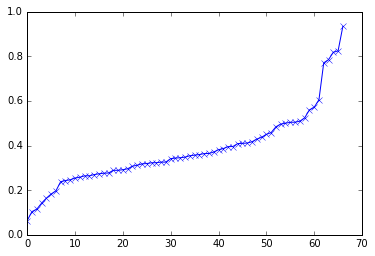

(Normalizer(copy=True, norm='l2'),
 StandardScaler(copy=True, with_mean=True, with_std=True),
 LogisticRegression(C=1.0, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False))

In [42]:
def test(features, labels, subject):
    xs_train, xs_test, ts_train, ts_test = sklearn.cross_validation.train_test_split(
            features, labels, test_size=0.2, random_state=0)

    normaliser = sklearn.preprocessing.Normalizer()
    scaler = sklearn.preprocessing.StandardScaler().fit(normaliser.transform(xs_train[:, -6:]))
    xs_train = numpy.hstack([normaliser.transform(xs_train[:, :-6]),
                             scaler.transform(normaliser.transform(xs_train[:, -6:]))])
    xs_test = numpy.hstack([normaliser.transform(xs_test[:, :-6]),
                             scaler.transform(normaliser.transform(xs_test[:, -6:]))])

    lr = sklearn.linear_model.LogisticRegression(class_weight='balanced')
    lr.fit(xs_train, ts_train)
    print('Classification accuracy: {:.02%}'.format(lr.score(xs_test, ts_test)))

    subject_id = str(subject['_id']).encode('ascii')
    indices = (data['subject_id'] == subject_id).as_matrix().reshape(-1)
    potential_hosts = numpy.nan_to_num(data.as_matrix()[indices][:, 1:-1].astype(float))
    labels = numpy.nan_to_num(data.as_matrix()[indices][:, -1].astype(bool))

    radio = crowdastro.data.get_radio(subject, size='5x5')

    radio_patches = numpy.zeros((len(potential_hosts), 1, radius * 2, radius * 2))
    linear_features = numpy.zeros((len(potential_hosts), 1))
    for index, (x, y, *astro) in enumerate(potential_hosts):
        patch = radio[x - radius + padding : x + radius + padding, y - radius + padding : y + radius + padding]
        radio_patches[index, 0, :] = patch
        linear_features[index] = numpy.hypot(x - 100, y - 100)

    radio_features = cnn.predict(radio_patches) @ pca.T
    astro_features = potential_hosts[:, 2:]
    features = numpy.hstack([radio_features, astro_features, linear_features])
    features = numpy.hstack([normaliser.transform(features[:, :-6]),
                             scaler.transform(normaliser.transform(features[:, -6:]))])

    scores = lr.predict_proba(features)[:, 1].reshape(-1)
    matplotlib.pyplot.plot(sorted(scores), marker='x')
    matplotlib.pyplot.show()
    
    return normaliser, scaler, lr

test(features, labels, subject)

One interesting fact is that this curve is *steeper* than for the non-scaled/non-normalised/no distance classifier.